In [1]:
from PIL import Image
import os
import cv2
import numpy as np
import xml.etree.ElementTree as ET
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
import torch.nn.functional as F
import torchvision.ops as ops 
from torchvision.ops import roi_pool
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV

/Users/matvejzasadko/.pyenv/versions/3.8.13/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/matvejzasadko/.pyenv/versions/3.8.13/lib/python3.8/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.16). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
data = {
    'filename': [],
    'width': [],
    'height': [],
    'class': [],
    'xmin': [],
    'ymin': [],
    'xmax': [],
    'ymax': []
}

In [3]:
def get_file_image_dimensions(file_path):
    if not os.path.isfile(file_path):
        return None, None
    with Image.open(file_path) as img:
        width, height = img.size
    return width, height

def get_xml_image_dimensions(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    size = root.find('size')
    if size is not None:
        width = size.find('width').text
        height = size.find('height').text
        if width and height:
            return int(width), int(height)
    return 0, 0  


def get_image_dimensions(xml_file, image_file_path):
    width, height = get_xml_image_dimensions(xml_file)
    
    if width == 0 or height == 0:
        width, height = get_file_image_dimensions(image_file_path)
        
    return width, height


def parse_xml(xml_file, image_file_path):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    filename = root.find('filename').text
    
    width, height = get_image_dimensions(xml_file, image_file_path)


    for obj in root.iter('object'):
        obj_class = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)

        data['filename'].append(filename)
        data['width'].append(width)
        data['height'].append(height)
        data['class'].append(obj_class)
        data['xmin'].append(xmin)
        data['ymin'].append(ymin)
        data['xmax'].append(xmax)
        data['ymax'].append(ymax)


In [4]:
class FruitDataset(Dataset):
    def __init__(self, data_dir, transforms=None, image_size=(256, 256)):
        self.data_dir = data_dir
        self.transforms = transforms
        self.image_size = image_size 
        
        self.images = [f for f in os.listdir(data_dir) if f.endswith('.jpg')]
        
        for image_file in self.images:
            xml_file = image_file.replace('.jpg', '.xml')
            xml_path = os.path.join(data_dir, xml_file)
            image_path = os.path.join(data_dir, image_file)
            if os.path.exists(xml_path):
                parse_xml(xml_path, image_path)
        
        self.dataframe = pd.DataFrame(data)

    def __len__(self):
        return len(self.images)
    
    def class_to_label(self, class_name):
        class_mapping = {'apple': 0, 'banana': 1, 'orange': 2}
        return class_mapping.get(class_name, 0) 
    
    def __getitem__(self, idx):
        image_name = self.images[idx]
        image_path = os.path.join(self.data_dir, image_name)

    # Завантажуємо зображення
        image = cv2.imread(image_path)
    
    # Перетворюємо в RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

        boxes = []
        labels = []
    
        image_data = self.dataframe[self.dataframe['filename'] == image_name]
        for _, row in image_data.iterrows():
            xmin = row['xmin']
            ymin = row['ymin']
            xmax = row['xmax']
            ymax = row['ymax']
            label = self.class_to_label(row['class'])
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(label)
    
        orig_height, orig_width = image.shape[:2]
    
    # Приведення всіх зображень до одного розміру
        image = cv2.resize(image, self.image_size)
    
    # Пропорційне масштабування bounding boxes
        scale_x = self.image_size[0] / orig_width
        scale_y = self.image_size[1] / orig_height
        boxes = [[xmin * scale_x, ymin * scale_y, xmax * scale_x, ymax * scale_y] for xmin, ymin, xmax, ymax in boxes]
    
        boxes = [[xmin / self.image_size[0], ymin / self.image_size[1], xmax / self.image_size[0], ymax / self.image_size[1]] for xmin, ymin, xmax, ymax in boxes]

        if self.transforms:
            transformed = self.transforms(image=image, bboxes=boxes, labels=labels)
            image = transformed['image']
            boxes = torch.as_tensor(transformed['bboxes'], dtype=torch.float32)

        labels = torch.as_tensor(labels, dtype=torch.int64)
    
        target = {"boxes": boxes, "labels": labels}
    
        return image, target

In [5]:
transform = A.Compose([
    
    # Дзеркально відображає зобреження, щоб в подальшому модель звикала до симетрії(обʼєкт може бути як ліворуч так і праворуч)
    A.HorizontalFlip(p=0.5),
    # Перевертає зображення щоб якщо обʼєкти були перевернутими, або нахиленимим, модель всеодно їх впізнавала
    A.Rotate(limit=15, p=0.5),
    # Допомагає моделі розпізнавати обʼєкти не залежно від умов освітлення
    A.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2, p=0.5),
    # моделі в PyTorch очікують вхідні дані у вигляді тензорів
    ToTensorV2(p=1.0),
], bbox_params=A.BboxParams(format='albumentations', label_fields=['labels']))

dataset = FruitDataset(data_dir='/Users/matvejzasadko/Downloads/All/Study/NNetworks/Lb1/archive/train_zip/train', transforms=transform, image_size=(256, 256))

dataloader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

for images, targets in dataloader:
    print(images[0].shape, targets[0]['boxes'])

torch.Size([3, 256, 256]) tensor([[0.1370, 0.2783, 0.6315, 0.8035]])
torch.Size([3, 256, 256]) tensor([[0.0000, 0.1158, 0.8675, 0.9570]])
torch.Size([3, 256, 256]) tensor([[0.0227, 0.0014, 0.6516, 0.2972]])
torch.Size([3, 256, 256]) tensor([[0.1200, 0.1026, 0.8900, 0.8462]])
torch.Size([3, 256, 256]) tensor([[0.1092, 0.1378, 0.5130, 0.9212],
        [0.4827, 0.0489, 0.8801, 0.7345]])
torch.Size([3, 256, 256]) tensor([[0.0808, 0.0000, 0.9314, 1.0000]])
torch.Size([3, 256, 256]) tensor([[0.0875, 0.0417, 0.3625, 0.3767],
        [0.0437, 0.3617, 0.3162, 0.7550],
        [0.2288, 0.2950, 0.4775, 0.6850],
        [0.7563, 0.4967, 0.9837, 0.8550],
        [0.6225, 0.6167, 0.8438, 0.9450],
        [0.4162, 0.3983, 0.7175, 0.7717],
        [0.2387, 0.5833, 0.4663, 0.9050],
        [0.5537, 0.7083, 0.8188, 0.9967]])
torch.Size([3, 256, 256]) tensor([[0.6438, 0.4283, 0.9350, 0.8733],
        [0.4238, 0.5750, 0.7225, 0.9483],
        [0.0125, 0.3983, 0.2675, 0.7850],
        [0.2412, 0.3183, 0.52

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


torch.Size([3, 256, 256]) tensor([[0.1167, 0.3764, 0.4075, 0.8381],
        [0.3242, 0.4228, 0.6817, 0.8632],
        [0.5175, 0.3476, 0.8042, 0.7779],
        [0.3042, 0.0765, 0.6708, 0.5257]])
torch.Size([3, 256, 256]) tensor([[0.0240, 0.1080, 0.6840, 0.7720]])
torch.Size([3, 256, 256]) tensor([[0.2620, 0.2216, 0.7819, 0.7163]])
torch.Size([3, 256, 256]) tensor([[0.3841, 0.1253, 0.7331, 0.6071],
        [0.1441, 0.2691, 0.4733, 0.7505],
        [0.2077, 0.3587, 0.9765, 0.9639]])
torch.Size([3, 256, 256]) tensor([[0.0833, 0.1400, 0.9167, 0.9900]])
torch.Size([3, 256, 256]) tensor([[0.2542, 0.2806, 0.6906, 0.8333],
        [0.6917, 0.1778, 0.9573, 0.5125]])
torch.Size([3, 256, 256]) tensor([[0.1841, 0.0077, 1.0000, 1.0000]])
torch.Size([3, 256, 256]) tensor([[0.1654, 0.2305, 0.8808, 0.8475]])
torch.Size([3, 256, 256]) tensor([[0.1439, 0.1909, 0.9045, 0.8061]])
torch.Size([3, 256, 256]) tensor([[0.0445, 0.0860, 0.9161, 1.0000]])
torch.Size([3, 256, 256]) tensor([[0.0971, 0.3173, 0.8110,

libpng warning: iCCP: known incorrect sRGB profile


torch.Size([3, 256, 256]) tensor([[0.1459, 0.0439, 0.6137, 0.6455],
        [0.3771, 0.0852, 0.9082, 0.7686],
        [0.0000, 0.2139, 0.8640, 1.0000]])
torch.Size([3, 256, 256]) tensor([[0.3040, 0.1097, 0.5176, 0.4501],
        [0.5370, 0.1919, 0.7312, 0.5489],
        [0.5070, 0.5134, 0.7493, 0.8748]])
torch.Size([3, 256, 256]) tensor([[0.4731, 0.3150, 0.9156, 0.9221],
        [0.0705, 0.4095, 0.7230, 0.9517],
        [0.0894, 0.2228, 0.7289, 0.6759]])
torch.Size([3, 256, 256]) tensor([[0.2165, 0.1702, 0.9529, 0.6170],
        [0.0706, 0.2376, 0.5953, 1.0000],
        [0.1788, 0.2695, 0.8659, 0.7979]])
torch.Size([3, 256, 256]) tensor([[0.4023, 0.1011, 0.7264, 0.8362]])
torch.Size([3, 256, 256]) tensor([[0.0000, 0.1643, 1.0000, 1.0000]])
torch.Size([3, 256, 256]) tensor([[0.3169, 0.1390, 0.8575, 0.6669]])
torch.Size([3, 256, 256]) tensor([[0.0080, 0.0740, 0.6800, 0.8000]])
torch.Size([3, 256, 256]) tensor([[0.1689, 0.1011, 0.8360, 0.9212],
        [0.3617, 0.1165, 0.9677, 1.0000],
  

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.ops import roi_pool

class RCNN(nn.Module):
    def __init__(self, num_classes, num_rois=9):
        super(RCNN, self).__init__()
        
        self.feature_extractor = models.alexnet(pretrained=True).features
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout()
        )
        
        self.bbox_head = nn.Linear(4096, num_rois * 4)
        
        self.class_head = nn.Linear(4096, num_rois * num_classes)
        
        self.num_classes = num_classes
        self.num_rois = num_rois

    def forward(self, x, rois):
        features = self.feature_extractor(x)
        
        pooled_features = roi_pool(features, rois, output_size=(6, 6))
        
        x = self.avgpool(pooled_features)
        x = self.fc(x)

        bbox_coords = self.bbox_head(x)
        bbox_coords = bbox_coords.view(-1, self.num_rois, 4)

        class_scores = self.class_head(x)
        class_scores = class_scores.view(-1, self.num_rois, self.num_classes)
        
        return bbox_coords, class_scores

num_classes = 4 
num_rois = 9
model = RCNN(num_classes=num_classes, num_rois=num_rois)

dummy_input = torch.randn(1, 3, 512, 512) 
dummy_rois = torch.tensor([[0, 50, 50, 400, 400]], dtype=torch.float)

bbox_coords, class_scores = model(dummy_input, dummy_rois)

print("Bounding Box Coordinates:", bbox_coords)
print("Class Scores:", class_scores)

In [10]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn

num_epochs = 20
learning_rate = 0.00001

num_classes = 3 
num_rois = 9
model = RCNN(num_classes=num_classes, num_rois=num_rois)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

bbox_loss_fn = nn.MSELoss() 
class_loss_fn = nn.CrossEntropyLoss() 

for epoch in range(num_epochs):
    model.train()
    total_bbox_loss = 0.0
    total_class_loss = 0.0
    
    for images, targets in dataloader: 
        images = torch.stack(images).to(device)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        rois = []
        for idx in range(len(images)):
            roi = torch.tensor([[idx, 50, 50, 400, 400],
                                [idx, 100, 100, 300, 300]], dtype=torch.float, device=device)
            rois.append(roi)
        
        rois = torch.cat(rois, dim=0) 
        
        bbox_preds, class_preds = model(images, rois)
        
        batch_bbox_loss = 0.0
        batch_class_loss = 0.0

        for i, target in enumerate(targets):
            num_boxes = target['boxes'].shape[0]
            if num_boxes > num_rois:
                bboxes = target['boxes'][:num_rois]
                labels = target['labels'][:num_rois]
            else:
                padding_boxes = torch.zeros((num_rois - num_boxes, 4), device=device)
                padding_labels = torch.zeros(num_rois - num_boxes, dtype=torch.long, device=device)
                bboxes = torch.cat([target['boxes'], padding_boxes], dim=0)
                labels = torch.cat([target['labels'], padding_labels], dim=0)
                
            batch_bbox_loss += bbox_loss_fn(bbox_preds[i], bboxes)
            batch_class_loss += class_loss_fn(class_preds[i], labels)
        
        batch_bbox_loss /= len(targets)
        batch_class_loss /= len(targets)

        loss = batch_bbox_loss + batch_class_loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_bbox_loss += batch_bbox_loss.item()
        total_class_loss += batch_class_loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], BBox Loss: {total_bbox_loss/len(dataloader):.4f}, Class Loss: {total_class_loss/len(dataloader):.4f}")

print("Тренування завершено.")


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch [1/20], BBox Loss: 0.1433, Class Loss: 1.0882


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch [2/20], BBox Loss: 0.1349, Class Loss: 1.0681


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch [3/20], BBox Loss: 0.1256, Class Loss: 1.0369


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch [4/20], BBox Loss: 0.1058, Class Loss: 0.9837


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch [5/20], BBox Loss: 0.0822, Class Loss: 0.9086


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch [6/20], BBox Loss: 0.0660, Class Loss: 0.8236


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch [7/20], BBox Loss: 0.0543, Class Loss: 0.7487


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch [8/20], BBox Loss: 0.0518, Class Loss: 0.7004


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch [9/20], BBox Loss: 0.0524, Class Loss: 0.6731


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch [10/20], BBox Loss: 0.0519, Class Loss: 0.6589


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch [11/20], BBox Loss: 0.0512, Class Loss: 0.6541


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch [12/20], BBox Loss: 0.0512, Class Loss: 0.6498


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch [13/20], BBox Loss: 0.0517, Class Loss: 0.6468


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch [14/20], BBox Loss: 0.0520, Class Loss: 0.6452


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch [15/20], BBox Loss: 0.0516, Class Loss: 0.6443


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch [16/20], BBox Loss: 0.0513, Class Loss: 0.6434


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch [17/20], BBox Loss: 0.0518, Class Loss: 0.6437


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch [18/20], BBox Loss: 0.0512, Class Loss: 0.6434


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch [19/20], BBox Loss: 0.0522, Class Loss: 0.6439


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch [20/20], BBox Loss: 0.0511, Class Loss: 0.6411
Тренування завершено.


In [11]:
from sklearn.metrics import accuracy_score

test_dataset = FruitDataset(data_dir='/Users/matvejzasadko/Downloads/All/Study/NNetworks/Lb1/archive/test_zip/test', 
                            transforms=transform, 
                            image_size=(256, 256))

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

def evaluate_model(model, test_loader, device, num_rois=9):
    model.eval()  
    total_bbox_loss = 0.0
    all_true_labels = []
    all_pred_labels = []

    bbox_loss_fn = nn.MSELoss() 

    with torch.no_grad():  
        for images, targets in test_loader:
            images = torch.stack(images).to(device)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            rois = []
            for idx in range(len(images)):
                roi = torch.tensor([[idx, 50, 50, 400, 400],
                                    [idx, 100, 100, 300, 300]], dtype=torch.float, device=device)
                rois.append(roi)
            
            rois = torch.cat(rois, dim=0)  

            bbox_preds, class_preds = model(images, rois)

            batch_bbox_loss = 0.0

            for i, target in enumerate(targets):
                num_boxes = target['boxes'].shape[0]
                if num_boxes > num_rois:
                    bboxes = target['boxes'][:num_rois]
                    labels = target['labels'][:num_rois]
                else:
                    padding_boxes = torch.zeros((num_rois - num_boxes, 4), device=device)
                    padding_labels = torch.zeros(num_rois - num_boxes, dtype=torch.long, device=device)
                    bboxes = torch.cat([target['boxes'], padding_boxes], dim=0)
                    labels = torch.cat([target['labels'], padding_labels], dim=0)

                batch_bbox_loss += bbox_loss_fn(bbox_preds[i], bboxes).item()

                _, predicted_classes = torch.max(class_preds[i], 1)
                all_true_labels.extend(labels.cpu().numpy())
                all_pred_labels.extend(predicted_classes.cpu().numpy())

            total_bbox_loss += batch_bbox_loss / len(targets)

    avg_bbox_loss = total_bbox_loss / len(test_loader)

    class_accuracy = accuracy_score(all_true_labels, all_pred_labels)

    print(f"Тестова BBox Loss: {avg_bbox_loss:.4f}")
    print(f"Точність класифікації: {class_accuracy * 100:.2f}%")

evaluate_model(model, test_loader, device)


Тестова BBox Loss: 0.0498
Точність класифікації: 85.00%


libpng warning: iCCP: known incorrect sRGB profile


In [6]:
class RCNN_Tune(nn.Module):
    def __init__(self, num_classes, num_rois=9, fc_hidden_size=1024, dropout_rate=0.3, kernel_size=5, pretrained=True):
        super(RCNN_Tune, self).__init__()

        self.feature_extractor = models.alexnet(pretrained=pretrained).features
        self._update_kernel_size(kernel_size)
        
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 6 * 6, fc_hidden_size),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(fc_hidden_size, fc_hidden_size),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate)
        )

        self.bbox_head = nn.Linear(fc_hidden_size, num_rois * 4)
        self.class_head = nn.Linear(fc_hidden_size, num_rois * num_classes)
        
        self.num_classes = num_classes
        self.num_rois = num_rois

    def _update_kernel_size(self, kernel_size):
        
        for layer in self.feature_extractor:
            if isinstance(layer, nn.Conv2d):
                layer.kernel_size = (kernel_size, kernel_size)
                layer.padding = (kernel_size // 2, kernel_size // 2)  
        
    def forward(self, x, rois):
        features = self.feature_extractor(x)
        
        pooled_features = roi_pool(features, rois, output_size=(6, 6))
        
        x = self.avgpool(pooled_features)
        x = self.fc(x)

        bbox_coords = self.bbox_head(x)
        bbox_coords = bbox_coords.view(-1, self.num_rois, 4)

        class_scores = self.class_head(x)
        class_scores = class_scores.view(-1, self.num_rois, self.num_classes)
        
        return bbox_coords, class_scores


In [7]:
class PyTorchRCNNEstimator(BaseEstimator):
    def __init__(self, num_classes=4, num_rois=9, fc_hidden_size=4096, dropout_rate=0.5, kernel_size=3, learning_rate=0.001, num_epochs=5, pretrained=True):
        self.num_classes = num_classes
        self.num_rois = num_rois
        self.fc_hidden_size = fc_hidden_size
        self.dropout_rate = dropout_rate
        self.kernel_size = kernel_size
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.pretrained = pretrained
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = self._build_model()
        
    def _build_model(self):
        model = RCNN_Tune(num_classes=self.num_classes, num_rois=self.num_rois, 
                     fc_hidden_size=self.fc_hidden_size, dropout_rate=self.dropout_rate, 
                     kernel_size=self.kernel_size, pretrained=self.pretrained)
        model.to(self.device)
        return model
    
    def fit(self, X, y):
        self.model.train()
        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        bbox_loss_fn = nn.MSELoss()
        class_loss_fn = nn.CrossEntropyLoss()
        
        for epoch in range(self.num_epochs):
            total_bbox_loss = 0.0
            total_class_loss = 0.0
            
            for images, targets in dataloader:
                images = torch.stack(images).to(self.device)
                targets = [{k: v.to(self.device) for k, v in t.items()} for t in targets]
                
                rois = torch.cat([torch.tensor([[idx, 50, 50, 400, 400], [idx, 100, 100, 300, 300]], dtype=torch.float, device=self.device) for idx in range(len(images))], dim=0)
                bbox_preds, class_preds = self.model(images, rois)
                
                batch_bbox_loss = 0.0
                batch_class_loss = 0.0
                
                for i, target in enumerate(targets):
                    num_boxes = target['boxes'].shape[0]
                    if num_boxes > self.model.num_rois:
                        bboxes = target['boxes'][:self.model.num_rois]
                        labels = target['labels'][:self.model.num_rois]
                    else:
                        padding_boxes = torch.zeros((self.model.num_rois - num_boxes, 4), device=self.device)
                        padding_labels = torch.zeros(self.model.num_rois - num_boxes, dtype=torch.long, device=self.device)
                        bboxes = torch.cat([target['boxes'], padding_boxes], dim=0)
                        labels = torch.cat([target['labels'], padding_labels], dim=0)
                    
                    batch_bbox_loss += bbox_loss_fn(bbox_preds[i], bboxes)
                    batch_class_loss += class_loss_fn(class_preds[i], labels)
                
                batch_bbox_loss /= len(targets)
                batch_class_loss /= len(targets)
                
                loss = batch_bbox_loss + batch_class_loss
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                total_bbox_loss += batch_bbox_loss.item()
                total_class_loss += batch_class_loss.item()
        
        return self

    def score(self, X, y):
        self.model.eval()
        total_correct = 0
        total = 0
        with torch.no_grad():
            for images, targets in dataloader:
                images = torch.stack(images).to(self.device)
                targets = [{k: v.to(self.device) for k, v in t.items()} for t in targets]
                
                rois = torch.cat([torch.tensor([[idx, 50, 50, 400, 400], [idx, 100, 100, 300, 300]], dtype=torch.float, device=self.device) for idx in range(len(images))], dim=0)
                _, class_preds = self.model(images, rois)
                
                for i, target in enumerate(targets):
                    labels = target['labels'].to(self.device)
                    num_labels = min(len(labels), class_preds[i].shape[0])
                    pred_labels = class_preds[i][:num_labels].argmax(dim=1)
                    total_correct += (pred_labels == labels[:num_labels]).sum().item()
                    total += num_labels
        return total_correct / total


In [22]:
import itertools
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

param_grid = {
    'fc_hidden_size': [2048, 4096],
    'dropout_rate': [0.4, 0.5],
    'kernel_size': [5, 8],
    'learning_rate': [0.0001]
}

best_params = None
best_score = 0
results = []  

all_combinations = list(itertools.product(
    param_grid['fc_hidden_size'],
    param_grid['dropout_rate'],
    param_grid['kernel_size'],
    param_grid['learning_rate']
))

for fc_hidden_size, dropout_rate, kernel_size, learning_rate in all_combinations:
    print(f"Тестуємо: fc_hidden_size={fc_hidden_size}, dropout_rate={dropout_rate}, kernel_size={kernel_size}, learning_rate={learning_rate}")
    
    estimator = PyTorchRCNNEstimator(
        num_classes=4,
        num_rois=9,
        fc_hidden_size=fc_hidden_size,
        dropout_rate=dropout_rate,
        kernel_size=kernel_size,
        learning_rate=learning_rate,
        num_epochs=5
    )
    
    estimator.fit(None, None) 
    
    score = estimator.score(None, None)
    
    results.append({
        'fc_hidden_size': fc_hidden_size,
        'dropout_rate': dropout_rate,
        'kernel_size': kernel_size,
        'learning_rate': learning_rate,
        'accuracy': score
    })
    
    if score > best_score:
        best_score = score
        best_params = {
            'fc_hidden_size': fc_hidden_size,
            'dropout_rate': dropout_rate,
            'kernel_size': kernel_size,
            'learning_rate': learning_rate
        }
    print(f"Score: {score:.4f}\n")

print("Найкращі параметри:", best_params)
print("Найкращий результат:", best_score)

df = pd.DataFrame(results)
X = df[['fc_hidden_size', 'dropout_rate', 'kernel_size', 'learning_rate']]
y = df['accuracy']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_scaled, y)

feature_importances = model.feature_importances_

print("\nВажливість гіперпараметрів:")
for name, importance in zip(X.columns, feature_importances):
    print(f"{name}: {importance:.4f}")


Тестуємо: fc_hidden_size=2048, dropout_rate=0.4, kernel_size=5, learning_rate=0.0001


/Users/matvejzasadko/.pyenv/versions/3.8.13/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/matvejzasadko/.pyenv/versions/3.8.13/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng wa

Score: 0.1957

Тестуємо: fc_hidden_size=2048, dropout_rate=0.4, kernel_size=8, learning_rate=0.0001


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

Score: 0.1957

Тестуємо: fc_hidden_size=2048, dropout_rate=0.5, kernel_size=5, learning_rate=0.0001


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

Score: 0.1957

Тестуємо: fc_hidden_size=2048, dropout_rate=0.5, kernel_size=8, learning_rate=0.0001


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

Score: 0.1957

Тестуємо: fc_hidden_size=4096, dropout_rate=0.4, kernel_size=5, learning_rate=0.0001


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

Score: 0.1957

Тестуємо: fc_hidden_size=4096, dropout_rate=0.4, kernel_size=8, learning_rate=0.0001


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

Score: 0.1957

Тестуємо: fc_hidden_size=4096, dropout_rate=0.5, kernel_size=5, learning_rate=0.0001


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

Score: 0.1957

Тестуємо: fc_hidden_size=4096, dropout_rate=0.5, kernel_size=8, learning_rate=0.0001


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

Score: 0.1957

Найкращі параметри: {'fc_hidden_size': 2048, 'dropout_rate': 0.4, 'kernel_size': 5, 'learning_rate': 0.0001}
Найкращий результат: 0.1956989247311828

Важливість гіперпараметрів:
fc_hidden_size: 0.0000
dropout_rate: 0.0000
kernel_size: 0.0000
learning_rate: 0.0000


/Users/matvejzasadko/.pyenv/versions/3.8.13/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/matvejzasadko/.pyenv/versions/3.8.13/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch [1/15], BBox Loss: 0.0766, Class Loss: 1.0930
Найкращі ваги збережені на епосі 1 з BBox Loss: 0.0766


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch [2/15], BBox Loss: 0.0762, Class Loss: 1.0838
Найкращі ваги збережені на епосі 2 з BBox Loss: 0.0762


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch [3/15], BBox Loss: 0.0736, Class Loss: 1.0733
Найкращі ваги збережені на епосі 3 з BBox Loss: 0.0736


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch [4/15], BBox Loss: 0.0712, Class Loss: 1.0603
Найкращі ваги збережені на епосі 4 з BBox Loss: 0.0712


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch [5/15], BBox Loss: 0.0684, Class Loss: 1.0438
Найкращі ваги збережені на епосі 5 з BBox Loss: 0.0684


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch [6/15], BBox Loss: 0.0658, Class Loss: 1.0222
Найкращі ваги збережені на епосі 6 з BBox Loss: 0.0658


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch [7/15], BBox Loss: 0.0643, Class Loss: 0.9953
Найкращі ваги збережені на епосі 7 з BBox Loss: 0.0643


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch [8/15], BBox Loss: 0.0577, Class Loss: 0.9609
Найкращі ваги збережені на епосі 8 з BBox Loss: 0.0577


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch [9/15], BBox Loss: 0.0538, Class Loss: 0.9189
Найкращі ваги збережені на епосі 9 з BBox Loss: 0.0538


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch [10/15], BBox Loss: 0.0491, Class Loss: 0.8698
Найкращі ваги збережені на епосі 10 з BBox Loss: 0.0491


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch [11/15], BBox Loss: 0.0435, Class Loss: 0.8134
Найкращі ваги збережені на епосі 11 з BBox Loss: 0.0435


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch [12/15], BBox Loss: 0.0396, Class Loss: 0.7546
Найкращі ваги збережені на епосі 12 з BBox Loss: 0.0396


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch [13/15], BBox Loss: 0.0354, Class Loss: 0.6941
Найкращі ваги збережені на епосі 13 з BBox Loss: 0.0354


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch [14/15], BBox Loss: 0.0334, Class Loss: 0.6345
Найкращі ваги збережені на епосі 14 з BBox Loss: 0.0334


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Epoch [15/15], BBox Loss: 0.0313, Class Loss: 0.5814
Найкращі ваги збережені на епосі 15 з BBox Loss: 0.0313
Завантажено найкращі ваги в model_param.
Тренування завершено.


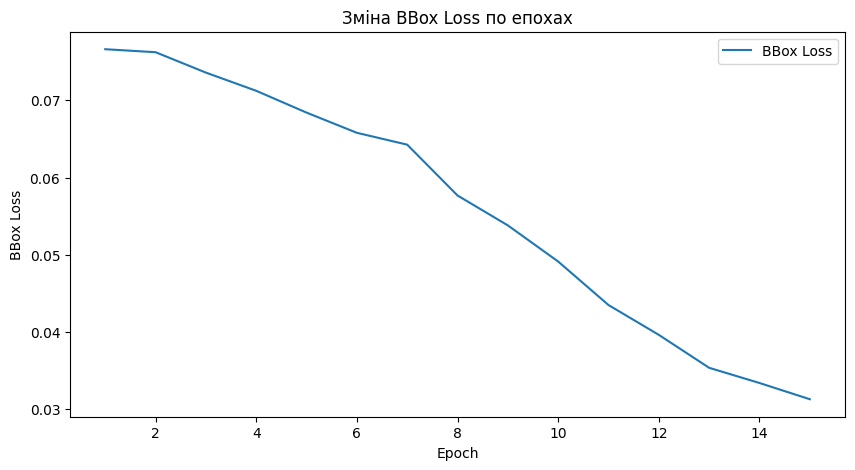

In [8]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

num_epochs = 15
learning_rate = 0.00001

num_classes = 3 
num_rois = 9
model_param = RCNN_Tune(num_classes=num_classes, num_rois=num_rois)
optimizer = optim.Adam(model_param.parameters(), lr=learning_rate)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_param.to(device)

bbox_loss_fn = nn.MSELoss() 
class_loss_fn = nn.CrossEntropyLoss() 

bbox_loss_history = []
class_loss_history = []

best_bbox_loss = float('inf')
best_model_state = None  

for epoch in range(num_epochs):
    model_param.train()
    total_bbox_loss = 0.0
    total_class_loss = 0.0
    
    for images, targets in dataloader: 
        images = torch.stack(images).to(device)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        rois = []
        for idx in range(len(images)):
            roi = torch.tensor([[idx, 50, 50, 400, 400],
                                [idx, 100, 100, 300, 300]], dtype=torch.float, device=device)
            rois.append(roi)
        
        rois = torch.cat(rois, dim=0) 
        
        bbox_preds, class_preds = model_param(images, rois)
        
        batch_bbox_loss = 0.0
        batch_class_loss = 0.0

        for i, target in enumerate(targets):
            num_boxes = target['boxes'].shape[0]
            if num_boxes > num_rois:
                bboxes = target['boxes'][:num_rois]
                labels = target['labels'][:num_rois]
            else:
                padding_boxes = torch.zeros((num_rois - num_boxes, 4), device=device)
                padding_labels = torch.zeros(num_rois - num_boxes, dtype=torch.long, device=device)
                bboxes = torch.cat([target['boxes'], padding_boxes], dim=0)
                labels = torch.cat([target['labels'], padding_labels], dim=0)
                
            batch_bbox_loss += bbox_loss_fn(bbox_preds[i], bboxes)
            batch_class_loss += class_loss_fn(class_preds[i], labels)
        
        batch_bbox_loss /= len(targets)
        batch_class_loss /= len(targets)

        loss = batch_bbox_loss + batch_class_loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_bbox_loss += batch_bbox_loss.item()
        total_class_loss += batch_class_loss.item()
    
    avg_bbox_loss = total_bbox_loss / len(dataloader)
    avg_class_loss = total_class_loss / len(dataloader)
    bbox_loss_history.append(avg_bbox_loss)
    class_loss_history.append(avg_class_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], BBox Loss: {avg_bbox_loss:.4f}, Class Loss: {avg_class_loss:.4f}")
    
    if avg_bbox_loss < best_bbox_loss:
        best_bbox_loss = avg_bbox_loss
        best_model_state = model_param.state_dict() 
        print(f"Найкращі ваги збережені на епосі {epoch+1} з BBox Loss: {avg_bbox_loss:.4f}")

if best_model_state is not None:
    model_param.load_state_dict(best_model_state)
    print("Завантажено найкращі ваги в model_param.")

print("Тренування завершено.")

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), bbox_loss_history, label='BBox Loss')
plt.xlabel('Epoch')
plt.ylabel('BBox Loss')
plt.title('Зміна BBox Loss по епохах')
plt.legend()
plt.show()


In [9]:
from sklearn.metrics import accuracy_score

test_dataset = FruitDataset(data_dir='/Users/matvejzasadko/Downloads/All/Study/NNetworks/Lb1/archive/test_zip/test', 
                            transforms=transform, 
                            image_size=(256, 256))

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

def evaluate_model(model, test_loader, device, num_rois=9):
    model.eval()  
    total_bbox_loss = 0.0
    all_true_labels = []
    all_pred_labels = []

    bbox_loss_fn = nn.MSELoss() 

    with torch.no_grad():  
        for images, targets in test_loader:
            images = torch.stack(images).to(device)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            rois = []
            for idx in range(len(images)):
                roi = torch.tensor([[idx, 50, 50, 400, 400],
                                    [idx, 100, 100, 300, 300]], dtype=torch.float, device=device)
                rois.append(roi)
            
            rois = torch.cat(rois, dim=0)  

            bbox_preds, class_preds = model(images, rois)

            batch_bbox_loss = 0.0

            for i, target in enumerate(targets):
                num_boxes = target['boxes'].shape[0]
                if num_boxes > num_rois:
                    bboxes = target['boxes'][:num_rois]
                    labels = target['labels'][:num_rois]
                else:
                    padding_boxes = torch.zeros((num_rois - num_boxes, 4), device=device)
                    padding_labels = torch.zeros(num_rois - num_boxes, dtype=torch.long, device=device)
                    bboxes = torch.cat([target['boxes'], padding_boxes], dim=0)
                    labels = torch.cat([target['labels'], padding_labels], dim=0)

                batch_bbox_loss += bbox_loss_fn(bbox_preds[i], bboxes).item()

                _, predicted_classes = torch.max(class_preds[i], 1)
                all_true_labels.extend(labels.cpu().numpy())
                all_pred_labels.extend(predicted_classes.cpu().numpy())

            total_bbox_loss += batch_bbox_loss / len(targets)

    avg_bbox_loss = total_bbox_loss / len(test_loader)

    class_accuracy2 = accuracy_score(all_true_labels, all_pred_labels)

    print(f"Тестова BBox Loss: {avg_bbox_loss:.4f}")
    print(f"Точність класифікації: {class_accuracy2 * 100:.2f}%")

evaluate_model(model_param, test_loader, device)

Тестова BBox Loss: 0.0274
Точність класифікації: 85.00%


libpng warning: iCCP: known incorrect sRGB profile


Epoch [7/10], BBox Loss: 0.0307, Class Loss: 0.4847 'fc_hidden_size': 2048, Epoch [9/10], BBox Loss: 0.0301, Class Loss: 0.4827 'dropout_rate': 0.4 Epoch [7/10], BBox Loss: 0.0299, Class Loss: 0.4830 'kernel_size': 5

Впорядковані за значимістю гіперпараметри - це 'kernel_size' 'dropout_rate' 'fc_hidden_size'
Найкращі параметри: {'fc_hidden_size': 2048, 'dropout_rate': 0.4, 'kernel_size': 5, 'learning_rate': 0.0001}
    
Але найкращий сет параметрів це базовий на тестових даних модель показала 
Тестова BBox Loss: 0.0297
Точність класифікації: 82.22%
    
А з параметрами: Тестова BBox Loss: 0.2716
                 Точність класифікації: 3.89%!!!!!!!!!!!! --Broken